In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
%matplotlib inline
import h5py
import os
import sys
import random
os.chdir("/s/ls4/groups/g0065/xfel/sbobkov/spi_euxfel")
import read_agipd
import glob
from scipy.signal import argrelextrema
from __future__ import print_function

In [34]:
def plot_data_cm(data, ax):
#     norm = colors.LogNorm(vmin=1,vmax=np.amax(data))
    im = ax.imshow(data, cmap="viridis")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis('off')
    
def plot_data_log(data, ax):
    vmin = 1
    vmax = np.amax(data)
    norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    data = np.clip(data, vmin, vmax)
    im = ax.imshow(data, cmap="viridis", norm=norm, interpolation='none')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis('off')

def plot_data(mean_data, ax):
    im = ax.imshow(mean_data, cmap="viridis")
    ax.axis('off')

In [3]:
run, panel, series = (348, 15, 2)
good_cells = range(2,62,2)

hdf_hits_file = '../../data/hits_r{:04d}.h5'.format(run)

with h5py.File(hdf_hits_file, 'r') as h5file:
    hits_trainid = h5file['TrainID'][:]
    hits_cellid = h5file['CellID'][:]
    hits_panel_adu = h5file['unassembled/adu'][:, panel]
    hits_panel_mask = h5file['unassembled/mask'][:, panel]
    hits_panel_background = h5file['unassembled/background'][:, panel]
    hits_panel_photons = h5file['unassembled/photons'][:, panel]


In [4]:

dset_base = '/INSTRUMENT/SPB_DET_AGIPD1M-1/DET/%dCH0:xtdf/image/' % panel
data_dset_name = dset_base+'data'
gain_dset_name = dset_base+'gain'
mask_dset_name = dset_base+'mask'
trainid_dset_name = dset_base+'trainId'
cellid_dset_name = dset_base+'cellId'

xfel_panel_adu = np.zeros_like(hits_panel_adu, dtype=np.int64)
xfel_panel_gain = np.zeros_like(hits_panel_adu, dtype=np.int64)
xfel_panel_mask = np.zeros_like(hits_panel_mask, dtype=np.int64)

for series in range(4):
    proc_file = '../Xfel_proc_p2013/CORR-R{:04d}-AGIPD{:02d}-S{:05d}.h5'.format(run, panel, series)

    with h5py.File(proc_file, 'r') as h5file:
        proc_data = h5file[data_dset_name]
        proc_gain = h5file[gain_dset_name]
        proc_mask = h5file[mask_dset_name]
        proc_trainid = h5file[trainid_dset_name][:,0]
        proc_cellid = h5file[cellid_dset_name][:]
        print(proc_data.shape, proc_trainid.shape, proc_cellid.shape )
        select_mask = np.zeros(proc_data.shape[0], dtype=bool)
        for i in range(len(hits_trainid)):
            frame_id_with_same_train = np.nonzero(hits_trainid[i]==proc_trainid)[0]
            if len(frame_id_with_same_train) == 0:
                continue
            frame_id = frame_id_with_same_train[0] + hits_cellid[i]
            xfel_panel_adu[i] = proc_data[frame_id]
            xfel_panel_gain[i] = proc_gain[frame_id]
            xfel_panel_mask[i] = proc_mask[frame_id].any(axis=2)

(16000, 512, 128) (16000,) (16000,)
(16000, 512, 128) (16000,) (16000,)
(16000, 512, 128) (16000,) (16000,)
(16000, 512, 128) (16000,) (16000,)


In [24]:
from matplotlib.backends.backend_pdf import PdfPages

In [5]:
xfel_panel_adu[xfel_panel_mask==0] = 0

In [50]:
pp = PdfPages('comparison_xfel_calibration.pdf')

for i in range(100):
    print('\r {}'.format(i),end='')
    fig, ax = plt.subplots(2, 1, figsize=(14,7))
    plt.suptitle('Run: {}, panel: {}, train id: {}, cell id: {}'.format(run, panel, hits_trainid[i], hits_cellid[i]), fontsize=16)
    plot_data_log(hits_panel_adu[i].transpose(), ax[0])
    ax[0].set_title("Calibration by KI team, based on Kartik's scripts")

    frame = np.clip(xfel_panel_adu[i], 0, np.amax(hits_panel_adu[i]))
    plot_data_log(frame.transpose(), ax[1])
    ax[1].set_title("Calibration by XFEL team (the same data range)")
    pp.savefig(fig, dpi=150, bbox_inches='tight')
    plt.close(fig)

pp.close()

 99

In [49]:
pp.close()

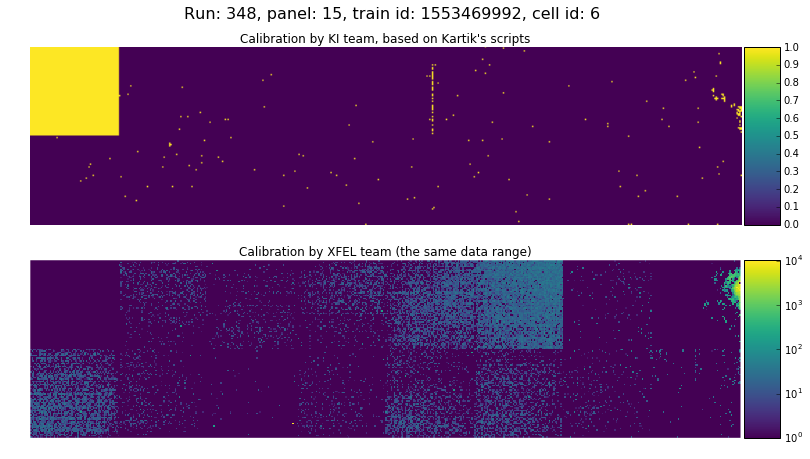

In [59]:
i=73
fig, ax = plt.subplots(2, 1, figsize=(14,7))
plt.suptitle('Run: {}, panel: {}, train id: {}, cell id: {}'.format(run, panel, hits_trainid[i], hits_cellid[i]), fontsize=16)
plot_data_cm(hits_panel_mask[i].transpose(), ax[0])
ax[0].set_title("Calibration by KI team, based on Kartik's scripts")

frame = np.clip(xfel_panel_adu[i], 0, np.amax(hits_panel_adu[i]))
plot_data_log(frame.transpose(), ax[1])
ax[1].set_title("Calibration by XFEL team (the same data range)")
    
pp = PdfPages('xfel_calibration_testpage.pdf')
pp.savefig(fig, dpi=150, bbox_inches='tight')
pp.close()

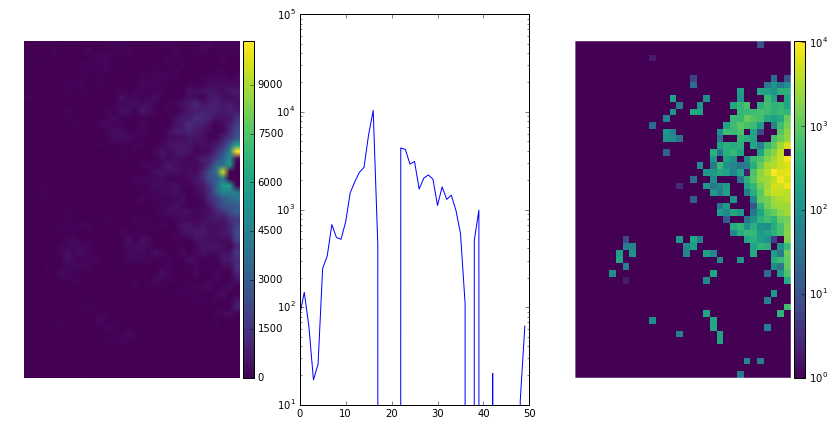

In [78]:
i=73
fig, ax = plt.subplots(1, 3, figsize=(14,7))
plot_data_cm(hits_panel_adu[i,480:,:50].transpose(), ax[0])
ax[1].plot(hits_panel_adu[i,-1,:50])
ax[1].set_yscale('log')

frame = np.clip(xfel_panel_adu[i,480:,:50], 0, np.amax(hits_panel_adu[i]))
plot_data_log(frame.transpose(), ax[2])

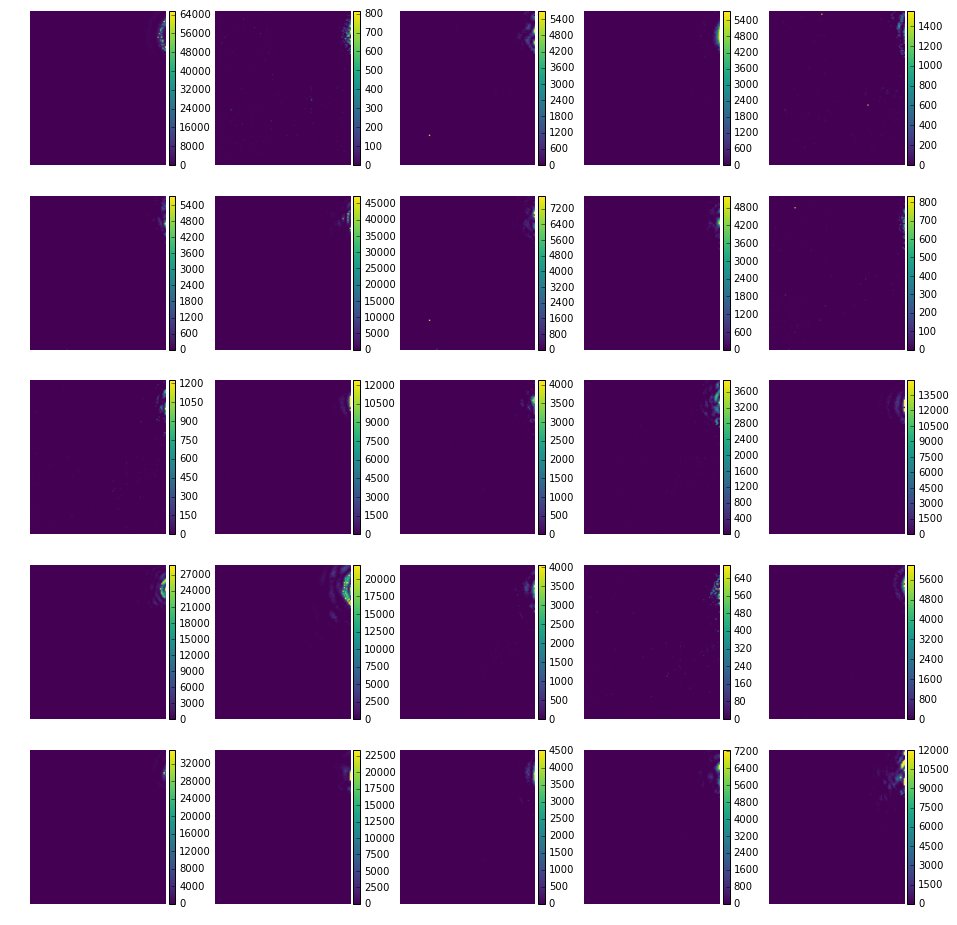

In [179]:
fig, ax = plt.subplots(5, 5, figsize=(16,16))
for i in range(25):
    frame = xfel_panel_adu[i]
    frame = np.clip(frame, 0, np.amax(hits_panel_adu[i]))
    frame[xfel_panel_mask[i]==0] = 0
    
    plot_data_cm(frame[400:].transpose(), ax.flatten()[i])